In [65]:
import pandas as pd
import time
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.tsa.stattools import acf, pacf

from linear_regression import performLinearRegr

In [67]:
def rmse(y_pred, y_true):
    MSE = mean_squared_error(y_true, y_pred)
    return math.sqrt(MSE)

def plot_series(df, title):
    plt.figure(figsize=(17, 2))
    plt.plot(df)    
    plt.xticks(rotation=45)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(16, 2))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.title('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

In [68]:
whole_df = pd.read_csv("/Users/cha/Desktop/Code/eCSpress/data/bdd_finale.csv")
whole_df['Date et heure de comptage'] = pd.to_datetime(whole_df['Date et heure de comptage'], format='%Y-%m-%d %H:%M:%S')
print("len whole_df", len(whole_df))
whole_df.columns

len whole_df 27548


Index(['Libelle', 'Date et heure de comptage', 'Débit horaire',
       'Taux d'occupation', 'Etat trafic', 'Etat arc_Barré',
       'Etat arc_Invalide', 'Jour férié', 'Jour de la semaine_0',
       'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
       'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
       'maxtempC', 'mintempC', 'avgtempC', 'totalSnow_cm', 'uvIndex', 'tempC',
       'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
       'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
       'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'is_day', 'paris_repsire',
       'perturbation_travaux'],
      dtype='object')

## Quelques plots pour le débit horaire aux Champs Elysées

nb instances 9186


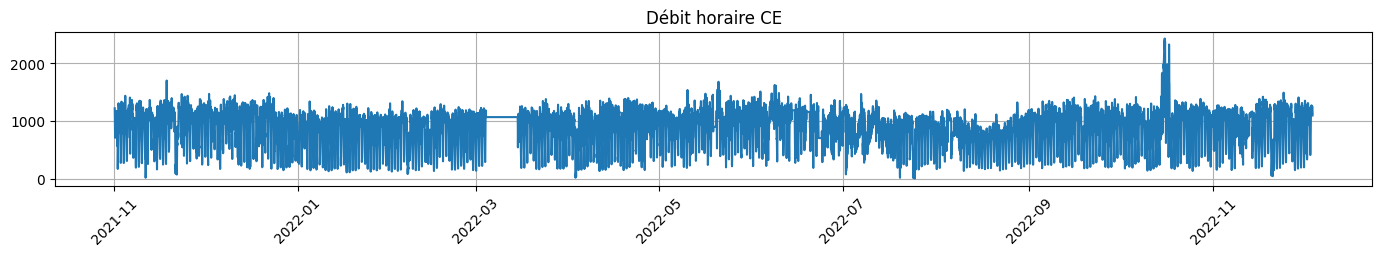

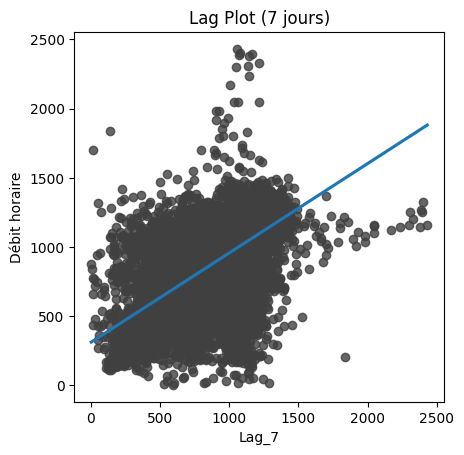

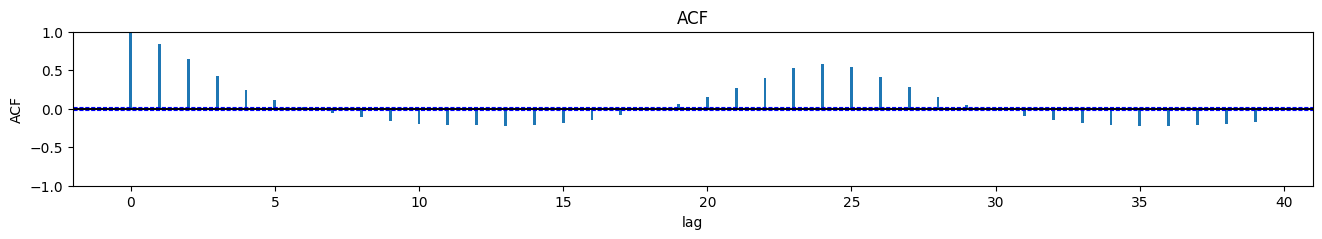

In [69]:
libelle = "AV_Champs_Elysees"
variable = 'Débit horaire'

ce_df = whole_df[whole_df["Libelle"]==libelle]
print("nb instances", len(ce_df))
ce_df = ce_df.sort_values(by='Date et heure de comptage')
ce_df = ce_df.reset_index(drop=True)
ce_df = ce_df.set_index('Date et heure de comptage')
ce_df = ce_df.asfreq('H', method= 'ffill')
ce_df['Lag_7'] = ce_df['Débit horaire'].shift(168)
plot_series(ce_df["Débit horaire"], "Débit horaire CE")

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_7', y='Débit horaire', data=ce_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot (7 jours)')

y = np.log(ce_df[variable])
y_len = len(y) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), y_len)

## Forward - Backward subset selection

In [71]:
features_tot = [
    'Lag_7', 'Etat trafic', 'Etat arc_Barré',
    'Etat arc_Invalide', 'Jour férié', 'Jour de la semaine_0',
    'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
    'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
    'maxtempC', 'mintempC', 'avgtempC', 'totalSnow_cm', 'uvIndex', 'tempC',
    'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
    'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
    'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'is_day', 'paris_repsire',
    'perturbation_travaux'
]
variables = ['Débit horaire', "Taux d'occupation"]

def processSubset(df, variable, feature_set, plot=False):
    X = df.loc[:, list(feature_set)]
    y = df.loc[:, variable]  # target

    # Dropping NaN values
    X.dropna(inplace=True)  # drop missing values in the feature set
    y, X = y.align(X, join='inner')  # drop corresponding values in target

    model = LinearRegression()
    regr = model.fit(X, y)
    y_pred = pd.Series(model.predict(X), index=X.index)
    RMSE = round(rmse(y_pred, y), 1)

    if plot:
        plot_params = dict(
            color="0.75",
            style=".-",
            markeredgecolor="0.25",
            markerfacecolor="0.25",
            legend=False,
        )

        ax = y.plot(**plot_params)
        ax = y_pred.plot(ax=ax, linewidth=3)
        ax.set_title('Plot')
    return {"model":regr, "RMSE":RMSE, "Features": feature_set}


def forward(df, variable, features):
    # Pull out features we still need to process
    remaining_features = [d for d in performLinearRegr.features_tot if d not in features]

    results = []

    for d in (remaining_features):
        result = processSubset(df, variable, features+[d])
        results.append(result)

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the lowest RMSE
    best_model = models.loc[models['RMSE'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model


def backward(df, variable, features):
    results = []
    
    for combo in tqdm(combinations(features, len(features)-1)):
        results.append(processSubset(df, variable, combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RMSE'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

# Convention

## Convention - Débit horaire

BACKWARD


34it [00:09,  3.67it/s]
33it [00:09,  3.51it/s]
32it [00:08,  3.59it/s]
31it [00:07,  4.00it/s]
30it [00:07,  4.19it/s]
29it [00:06,  4.31it/s]
28it [00:06,  4.44it/s]
27it [00:05,  5.22it/s]
26it [00:03,  7.11it/s]
25it [00:02,  9.34it/s]
24it [00:03,  7.14it/s]
23it [00:02, 10.14it/s]
22it [00:01, 16.23it/s]
21it [00:01, 19.52it/s]
20it [00:01, 18.58it/s]
19it [00:00, 23.67it/s]
18it [00:00, 33.96it/s]
17it [00:00, 33.01it/s]
16it [00:00, 40.31it/s]
15it [00:00, 38.64it/s]
14it [00:00, 48.26it/s]
13it [00:00, 72.73it/s]
12it [00:00, 76.82it/s]
11it [00:00, 62.83it/s]
10it [00:00, 83.73it/s]
9it [00:00, 88.89it/s]
8it [00:00, 156.71it/s]
7it [00:00, 120.40it/s]
6it [00:00, 82.96it/s]
5it [00:00, 174.93it/s]
4it [00:00, 195.20it/s]
3it [00:00, 119.23it/s]
2it [00:00, 356.63it/s]


FOREWARD


100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


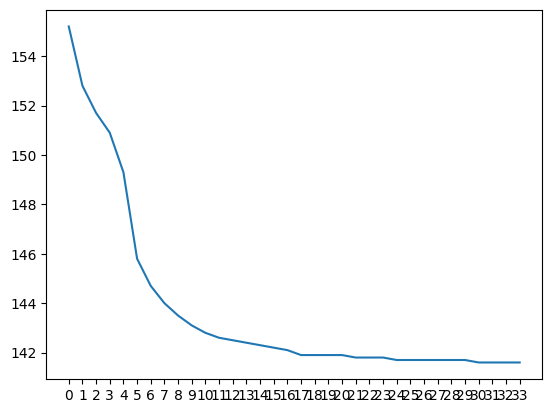

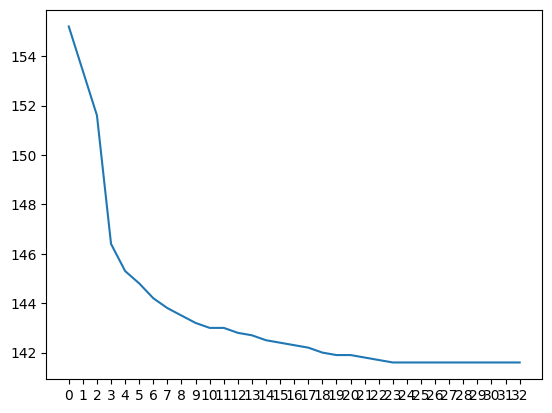

In [72]:
rue = "Convention"
variable = variables[0]

df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [74]:
ind = 9

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")
features_selected_conv_deb = models_bwd.loc[ind]["Features"]
print("RMSE", models_bwd.loc[ind]["RMSE"])
print(features_selected_conv_deb)

['Lag_7', 'is_day', 'Jour férié', 'humidity', 'maxtempC', 'DewPointC', 'mintempC', 'uvIndex', 'Jour de la semaine_6'] 

('Lag_7', 'Etat trafic', 'Jour férié', 'Jour de la semaine_4', 'avgtempC', 'uvIndex', 'humidity', 'DewPointC', 'is_day') 

RMSE 143.5
('Lag_7', 'Etat trafic', 'Jour férié', 'Jour de la semaine_4', 'avgtempC', 'uvIndex', 'humidity', 'DewPointC', 'is_day')


## Convention - Taux d'occupation

BACKWARD


34it [00:09,  3.67it/s]
33it [00:09,  3.60it/s]
32it [00:08,  3.71it/s]
31it [00:08,  3.83it/s]
30it [00:06,  4.84it/s]
29it [00:05,  5.02it/s]
28it [00:05,  5.02it/s]
27it [00:04,  5.64it/s]
26it [00:03,  7.25it/s]
25it [00:03,  8.19it/s]
24it [00:02,  9.19it/s]
23it [00:02,  7.96it/s]
22it [00:01, 12.23it/s]
21it [00:01, 19.79it/s]
20it [00:01, 16.75it/s]
19it [00:01, 17.65it/s]
18it [00:00, 26.51it/s]
17it [00:00, 24.73it/s]
16it [00:00, 29.46it/s]
15it [00:00, 38.32it/s]
14it [00:00, 52.84it/s]
13it [00:00, 50.18it/s]
12it [00:00, 70.97it/s]
11it [00:00, 79.44it/s]
10it [00:00, 64.86it/s]
9it [00:00, 69.70it/s]
8it [00:00, 74.94it/s]
7it [00:00, 77.75it/s]
6it [00:00, 144.78it/s]
5it [00:00, 86.98it/s]
4it [00:00, 87.03it/s]
3it [00:00, 96.33it/s]
2it [00:00, 160.75it/s]


FOREWARD


100%|██████████| 34/34 [00:26<00:00,  1.27it/s]


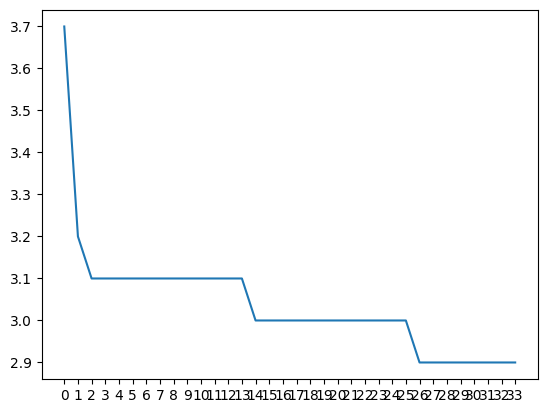

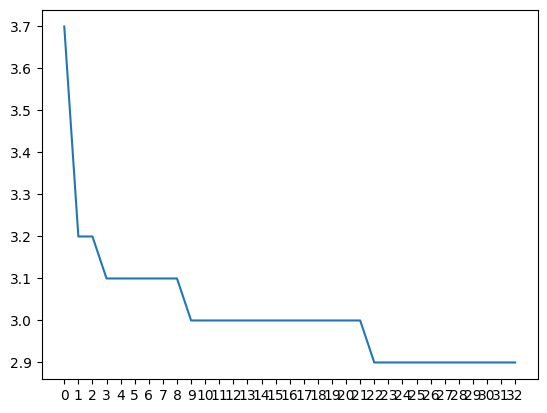

In [75]:
rue = "Convention"
variable = variables[1]


df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [77]:
ind = 4

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")
features_selected_conv_taux = models_fwd.loc[ind]["Features"]
print("RMSE", models_fwd.loc[ind]["RMSE"])
print(features_selected_conv_taux)

['Etat trafic', 'Lag_7', 'is_day', 'Etat arc_Barré'] 

('Lag_7', 'Etat trafic', 'maxtempC', 'tempC') 

RMSE 3.1
['Etat trafic', 'Lag_7', 'is_day', 'Etat arc_Barré']


# Saint Pères

## Saint Pères - Débit Horaire

BACKWARD


34it [00:08,  3.81it/s]
33it [00:09,  3.61it/s]
32it [00:09,  3.51it/s]
31it [00:08,  3.82it/s]
30it [00:06,  4.65it/s]
29it [00:06,  4.21it/s]
28it [00:06,  4.01it/s]
27it [00:05,  5.17it/s]
26it [00:04,  6.09it/s]
25it [00:02,  8.37it/s]
24it [00:02,  8.92it/s]
23it [00:02,  9.47it/s]
22it [00:01, 17.73it/s]
21it [00:02,  9.94it/s]
20it [00:01, 13.05it/s]
19it [00:00, 21.26it/s]
18it [00:00, 28.50it/s]
17it [00:00, 30.29it/s]
16it [00:00, 36.61it/s]
15it [00:00, 31.49it/s]
14it [00:00, 40.47it/s]
13it [00:00, 60.13it/s]
12it [00:00, 48.29it/s]
11it [00:00, 82.90it/s]
10it [00:00, 79.58it/s]
9it [00:00, 81.21it/s]
8it [00:00, 81.25it/s]
7it [00:00, 99.74it/s]
6it [00:00, 115.60it/s]
5it [00:00, 103.78it/s]
4it [00:00, 155.06it/s]
3it [00:00, 80.61it/s]
2it [00:00, 200.99it/s]


FOREWARD


100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


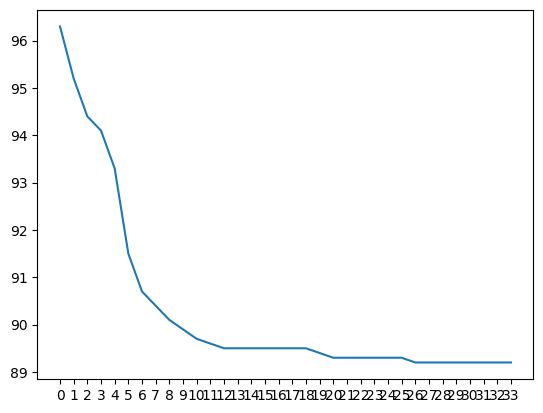

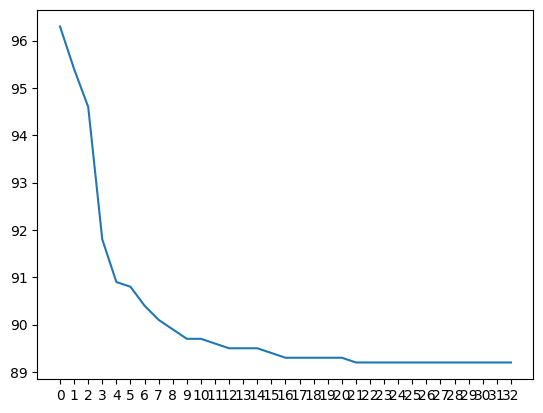

In [78]:
rue = "Sts_Peres"
variable = variables[0]


df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [79]:
ind = 8

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")
features_selected_peres_deb = models_bwd.loc[ind]["Features"]
print("RMSE", models_bwd.loc[ind]["RMSE"])
print(features_selected_peres_deb)

['Lag_7', 'is_day', 'Jour férié', 'humidity', 'maxtempC', 'DewPointC', 'mintempC', 'uvIndex'] 

('Lag_7', 'Jour férié', 'avgtempC', 'uvIndex', 'humidity', 'cloudcover', 'DewPointC', 'is_day') 

RMSE 90.1
('Lag_7', 'Jour férié', 'avgtempC', 'uvIndex', 'humidity', 'cloudcover', 'DewPointC', 'is_day')


## Saint Pères - Taux d'occupation

BACKWARD


34it [00:09,  3.63it/s]
33it [00:08,  3.69it/s]
32it [00:08,  3.65it/s]
31it [00:08,  3.78it/s]
30it [00:07,  3.97it/s]
29it [00:06,  4.36it/s]
28it [00:06,  4.60it/s]
27it [00:05,  4.63it/s]
26it [00:03,  8.11it/s]
25it [00:04,  5.77it/s]
24it [00:03,  7.83it/s]
23it [00:02, 10.06it/s]
22it [00:01, 19.32it/s]
21it [00:01, 11.80it/s]
20it [00:01, 18.17it/s]
19it [00:00, 21.92it/s]
18it [00:00, 29.69it/s]
17it [00:00, 29.70it/s]
16it [00:00, 30.41it/s]
15it [00:00, 28.46it/s]
14it [00:00, 48.09it/s]
13it [00:00, 58.51it/s]
12it [00:00, 61.68it/s]
11it [00:00, 49.07it/s]
10it [00:00, 109.00it/s]
9it [00:00, 63.28it/s]
8it [00:00, 146.01it/s]
7it [00:00, 77.41it/s]
6it [00:00, 103.42it/s]
5it [00:00, 96.54it/s]
4it [00:00, 185.52it/s]
3it [00:00, 87.17it/s]
2it [00:00, 154.86it/s]


FOREWARD


100%|██████████| 34/34 [00:24<00:00,  1.40it/s]


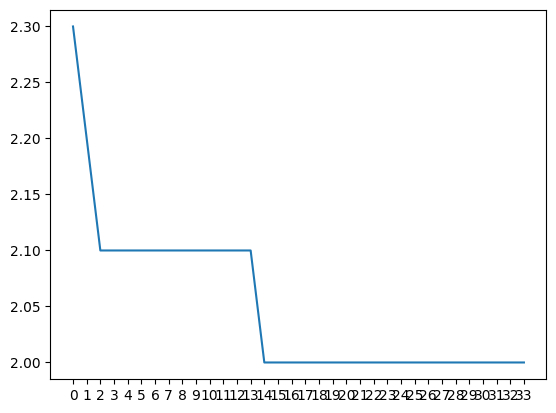

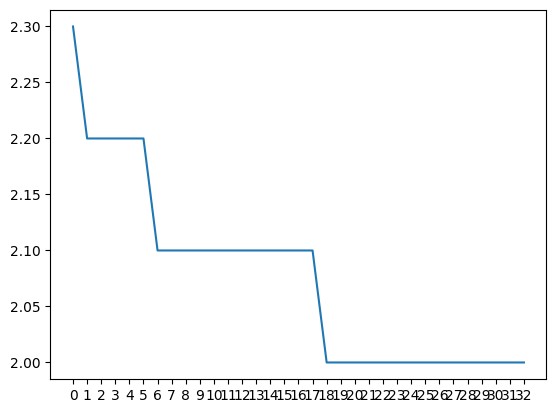

In [80]:
rue = "Sts_Peres"
variable = variables[1]


df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [81]:
ind = 3

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")

features_selected_peres_taux = models_fwd.loc[ind]["Features"]
print("RMSE", models_fwd.loc[ind]["RMSE"])
print(features_selected_peres_taux)

['Lag_7', 'Etat trafic', 'is_day'] 

('Lag_7', 'Etat trafic', 'Jour férié') 

RMSE 2.1
['Lag_7', 'Etat trafic', 'is_day']


# Champs Elysees

## Champs Elysees - Débit Horaire

BACKWARD


34it [00:09,  3.63it/s]
33it [00:09,  3.55it/s]
32it [00:08,  3.58it/s]
31it [00:08,  3.59it/s]
30it [00:07,  3.86it/s]
29it [00:06,  4.36it/s]
28it [00:06,  4.65it/s]
27it [00:05,  4.69it/s]
26it [00:03,  7.37it/s]
25it [00:03,  7.40it/s]
24it [00:02,  8.17it/s]
23it [00:02,  9.67it/s]
22it [00:01, 14.95it/s]
21it [00:01, 19.21it/s]
20it [00:01, 18.18it/s]
19it [00:00, 20.05it/s]
18it [00:00, 29.94it/s]
17it [00:00, 30.84it/s]
16it [00:00, 34.74it/s]
15it [00:00, 41.02it/s]
14it [00:00, 40.52it/s]
13it [00:00, 57.57it/s]
12it [00:00, 71.78it/s]
11it [00:00, 71.58it/s]
10it [00:00, 72.80it/s]
9it [00:00, 78.03it/s]
8it [00:00, 98.85it/s]
7it [00:00, 134.90it/s]
6it [00:00, 103.71it/s]
5it [00:00, 167.85it/s]
4it [00:00, 87.34it/s]
3it [00:00, 87.48it/s]
2it [00:00, 207.03it/s]


FOREWARD


100%|██████████| 34/34 [00:25<00:00,  1.35it/s]


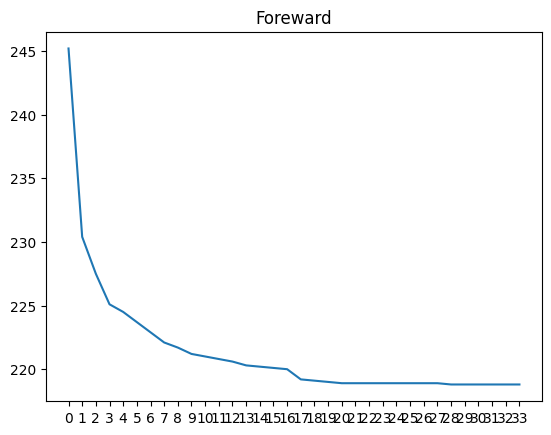

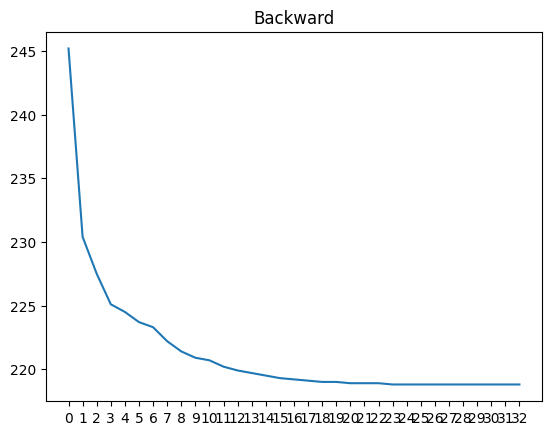

In [82]:
rue = "AV_Champs_Elysees"
variable = variables[0]


df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.title("Foreward")
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.title("Backward")
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [84]:
ind = 4

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")
features_selected_ce_deb = models_bwd.loc[ind]["Features"]
print("RMSE", models_bwd.loc[ind]["RMSE"])
print(features_selected_ce_deb)

['Lag_7', 'Etat trafic', 'is_day', 'Etat arc_Barré'] 

('Lag_7', 'Etat trafic', 'Etat arc_Barré', 'is_day') 

RMSE 225.1
('Lag_7', 'Etat trafic', 'Etat arc_Barré', 'is_day')


## Champs Elysees - Taux d'occupation

BACKWARD


34it [00:09,  3.57it/s]
33it [00:09,  3.56it/s]
32it [00:09,  3.48it/s]
31it [00:08,  3.62it/s]
30it [00:07,  3.79it/s]
29it [00:06,  4.23it/s]
28it [00:06,  4.31it/s]
27it [00:06,  4.18it/s]
26it [00:04,  6.28it/s]
25it [00:03,  6.80it/s]
24it [00:03,  7.62it/s]
23it [00:02,  9.88it/s]
22it [00:01, 12.98it/s]
21it [00:01, 20.07it/s]
20it [00:01, 17.98it/s]
19it [00:00, 22.29it/s]
18it [00:00, 29.26it/s]
17it [00:00, 37.66it/s]
16it [00:00, 33.98it/s]
15it [00:00, 28.96it/s]
14it [00:00, 43.78it/s]
13it [00:00, 61.25it/s]
12it [00:00, 42.95it/s]
11it [00:00, 53.66it/s]
10it [00:00, 56.12it/s]
9it [00:00, 85.64it/s]
8it [00:00, 118.91it/s]
7it [00:00, 120.61it/s]
6it [00:00, 188.21it/s]
5it [00:00, 136.22it/s]
4it [00:00, 135.74it/s]
3it [00:00, 125.78it/s]
2it [00:00, 298.55it/s]


FOREWARD


100%|██████████| 34/34 [00:25<00:00,  1.33it/s]


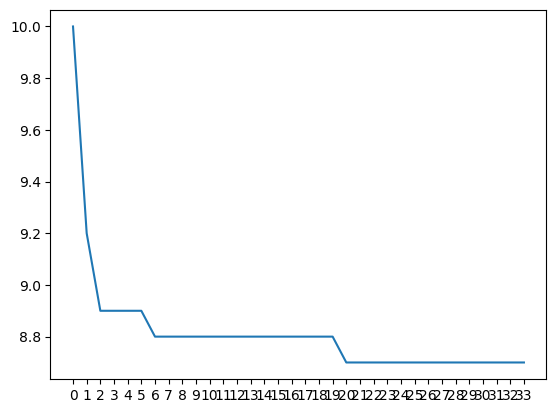

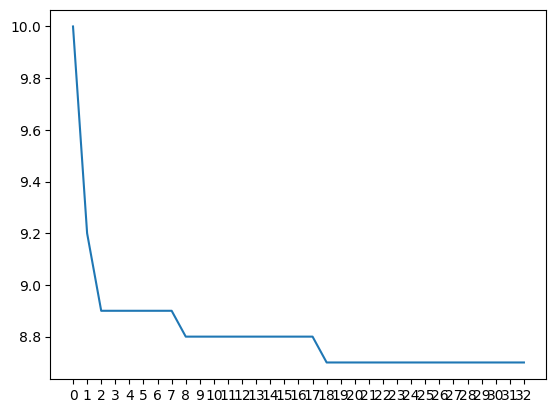

In [85]:
rue = "AV_Champs_Elysees"
variable = variables[1]

df = whole_df[whole_df["Libelle"]==rue]
df = df.sort_values(by='Date et heure de comptage')
df = df.reset_index(drop=True)
df = df.set_index('Date et heure de comptage')
df = df.asfreq('H', method= 'ffill')
df['Lag_7'] = df[variable].shift(168)

# Backward
print("BACKWARD")
models_bwd = pd.DataFrame(columns=["RMSE", "model", "Features"], index = range(1, len(features_tot)))
features = features_tot
while (len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(df, variable, features)
    features = models_bwd.loc[len(features)-1]["Features"]

# Forward
print("FOREWARD")
models_fwd = pd.DataFrame(columns=["RMSE", "model", "Features"])
features = []
for i in tqdm(range(1, len(features_tot)+1)):    
    models_fwd.loc[i] = forward(df, variable, features)
    features = models_fwd.loc[i]["Features"]

# Plot RMSE values
rmse_fwd = []
for line in models_fwd.index:
    rmse_fwd += [models_fwd.loc[line]["RMSE"]]
plt.plot(rmse_fwd)
plt.xticks(np.arange(len(rmse_fwd)))
plt.show()

rmse_bwd = []
for line in models_bwd.index:
    rmse_bwd += [models_bwd.loc[line]["RMSE"]]
plt.plot(rmse_bwd)
plt.xticks(np.arange(len(rmse_bwd)))
plt.show()

In [87]:
ind = 3

print(models_fwd.loc[ind]["Features"], "\n")
print(models_bwd.loc[ind]["Features"], "\n")
features_selected_ce_taux = models_bwd.loc[ind]["Features"]
print("RMSE", models_bwd.loc[ind]["RMSE"])
print(features_selected_ce_taux)

['Etat trafic', 'Lag_7', 'maxtempC'] 

('Lag_7', 'Etat trafic', 'maxtempC') 

RMSE 8.9
('Lag_7', 'Etat trafic', 'maxtempC')
